# 5 - Weather Database Access
***
2023.06.14
***

**Requirements:**
- Internet access
- NSRDB API key. API keys are free. You can request and obtain an API key in about 5 minutes. To get your own key, visit https://developer.nrel.gov/signup/
- Step **1.** is for Eagle HPC users. You will need an account with NREL's Eagle computer for this method.

**Objectives:**

Using direct access to large scale weather databases, we're going to estimate the minimum standoff distance for a roof mounted PV system. We'll do this in 3 ways using both the NSRDB and PVGIS database.
1. Single Location, NSRDB via NREL's high performance computer, Eagle.
2. Single Location via NSRDB public API key.
3. Single Location via the PVGIS public database

**Background:**

This journal will demonstrate all existing built-in methods for directly accessing public weather databases. Some methods are restriced to certain user groups. For general users, see methods **2** and **3**. For users with an active Eagle HPC account, you may use method **1** as well as **2** and **3**.

For all users and all steps: This journal will run significantly longer than other tutorials and have significant internet traffic as you fetch large datasets.

This example demonstrates the calculation of a minimum standoff distance necessary for roof-mounted PV modules to ensure that the $T_{98}$ operational temperature remains under 70°C, in which case the more rigorous thermal stability testing requirements of IEC TS 63126 would not needed to be considered. We use data from [Fuentes, 1987] to model the approximate exponential decay in temperature, $T(X)$, with increasing standoff distance, $X$, as,

$$ X = -X_0 \ln\left(1-\frac{T_0-T}{\Delta T}\right)$$

where $T_0$ is the temperature for $X=0$ (insulated back) and $\Delta T$ is the temperature difference between an insulated back ($X=0$) and open rack mounting configuration ($X=\infty)$.

The following figure showcases this calulation for the entire United States. We used pvlib and data from the National Solar Radiation Database (NSRDB) to calculate the module temperatures for different mounting configuration and applied our model to obtain the standoff distance for roof-mounted PV systems.

## Single location example

In [7]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
 # !pip install pvdeg==0.1.1

In [8]:
import pvdeg

## 1. NSRDB - HSDS on Eagle

This method requires a direct connection to NREL's high performance computer "Eagle". If you are not running this journal from Eagle, skip this section and proceed to section **2.**

In this step:

First we select a database. Here, we will use the NSRDB. Since we are modeling a single location, we can pass the `weather_id` as tuple (lat, long). A location gid can be used as well. 'gid' is a unique identifier to a geographic location within the NSRDB. We'll look at how to find gids later on.

Next, we want to select a satellite, named dataset (year of data), and what weather attributes we want to fetch. For further options, see the documentation for `pvdeg.weather.get`. This first method can get data from the map shown below.

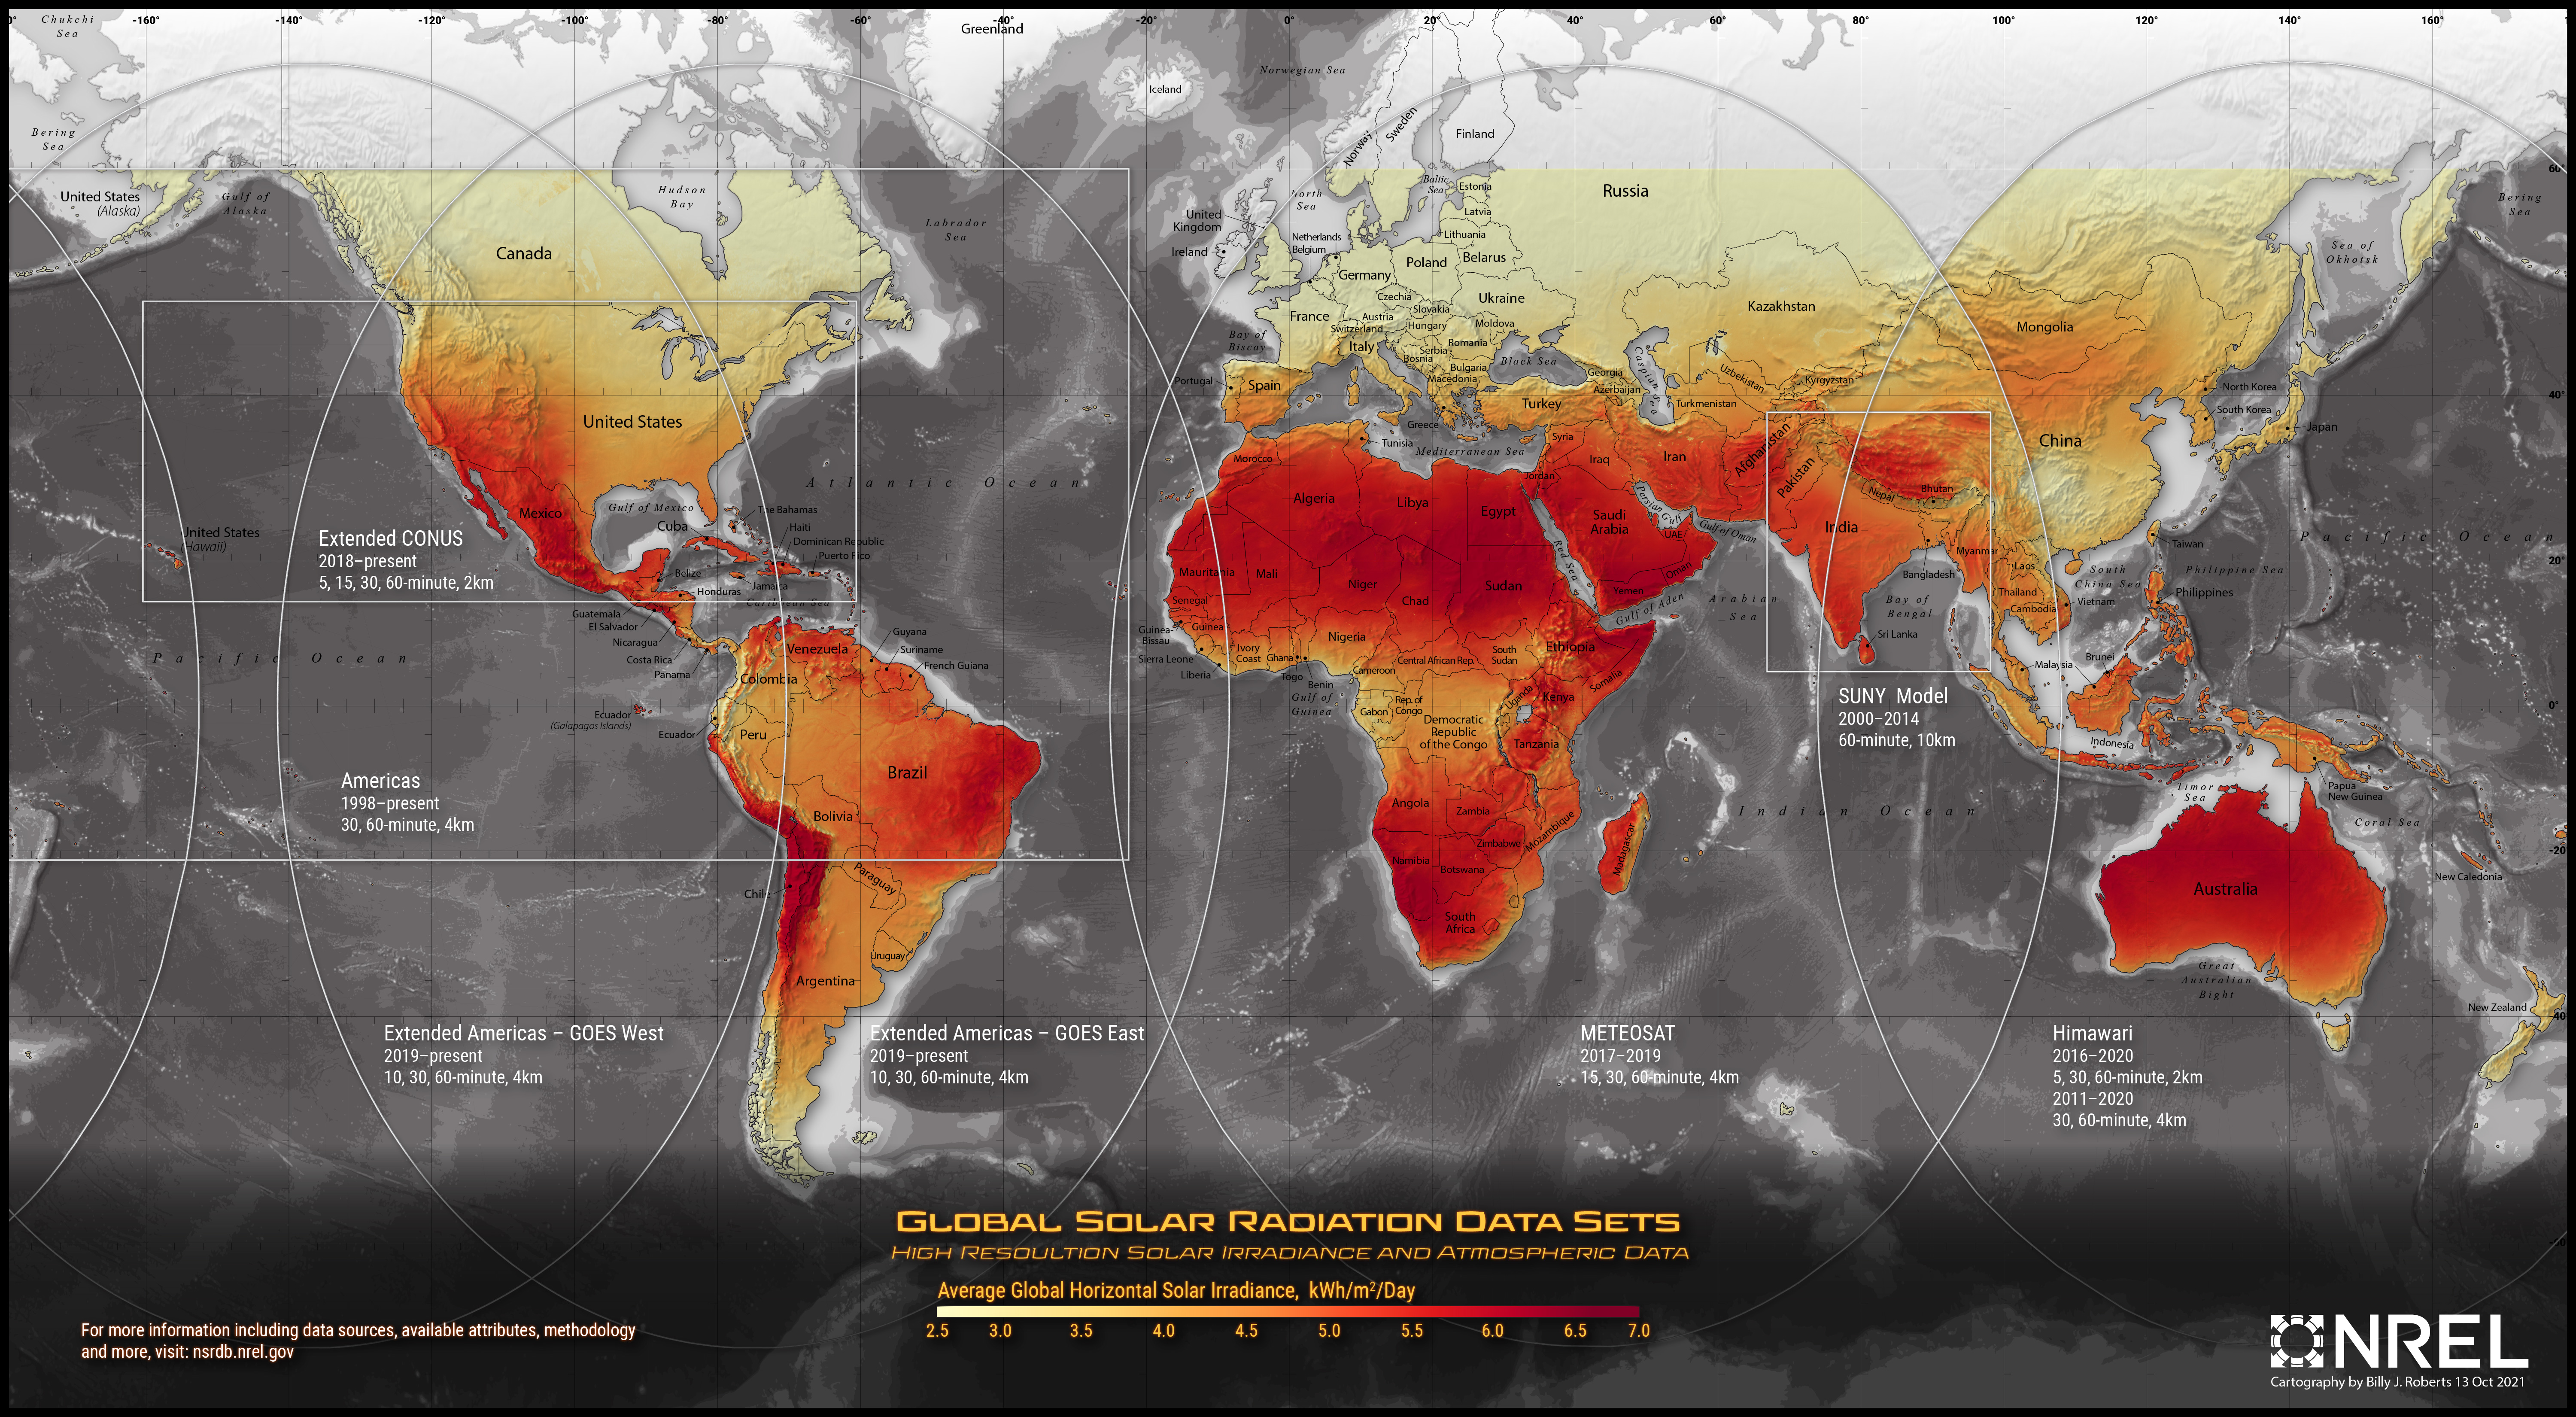

In [9]:
# Get weather data
weather_db = 'NSRDB'

#Latitude and Longitude
weather_id = (33.448376, -112.074036)
weather_id = (39.741931, -105.169891)
#weather_id = 1933572
weather_arg = {'satellite': 'GOES',
               'names': 2021,
               'NREL_HPC': True,
               'map_variables': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_df, meta = pvdeg.weather.get(weather_db, weather_id, **weather_arg)


`pvdeg.weather.get` returns the same variables as `weather.read` which we have used in each journal before this. We get a weather DataFrame and a meta-data dicitonary. Each contains a minimum of consistent fields, but may have additional fields based on the database accessed or the attributes requested.

Lets verify the weather data we fetched by running a familiar calculation; standoff distance.

In [10]:
res = pvdeg.standards.standoff(weather_df=weather_df, meta=meta, tilt=None, azimuth=180, sky_model='isotropic', temp_model='sapm',
    conf_0='insulated_back_glass_polymer', conf_inf='open_rack_glass_polymer', T98=70, x_0=6.5, wind_factor=0.33)
print(pvdeg.standards.interpret_standoff(res))
print(meta)


The estimated temperature of an insulated-back module is 79.1°C. 
The estimated temperature of an open-rack module is 54.0°C. 
Level 0 certification is valid for a standoff greather than 2.9 cm. 
Level 1 certification is required for a standoff less than 2.9 cm. 
Level 2 certification is never required for this temperature profile.
{'latitude': 39.7400016784668, 'longitude': -105.16999816894531, 'altitude': 1782, 'timezone': -7.0, 'country': 'United States', 'state': 'Colorado', 'county': 'Jefferson', 'wind_height': 2, 'Source': 'NSRDB'}


## 2. NSRDB - API

To access the NREL NSRDB, you will need an API key. Key's are free, but require you to set up an account. Without an API key, you can use a demonstration API which is severely limited. To set up an account and get your API key, visit https://developer.nrel.gov/signup/

Key Notes:
- set `attributes = []` to return all possible attributes (weather fields)
- There are 2 major methods with the API
    - names = 'tmy' : generate a TMY-like weather dataframe aggregate. This will calculate the relative humidity from temperature and dew point.
    - names = '2019' : collect a weather dataframe including measured relative humidity.
 
The map below indicates the locations where this method will work.

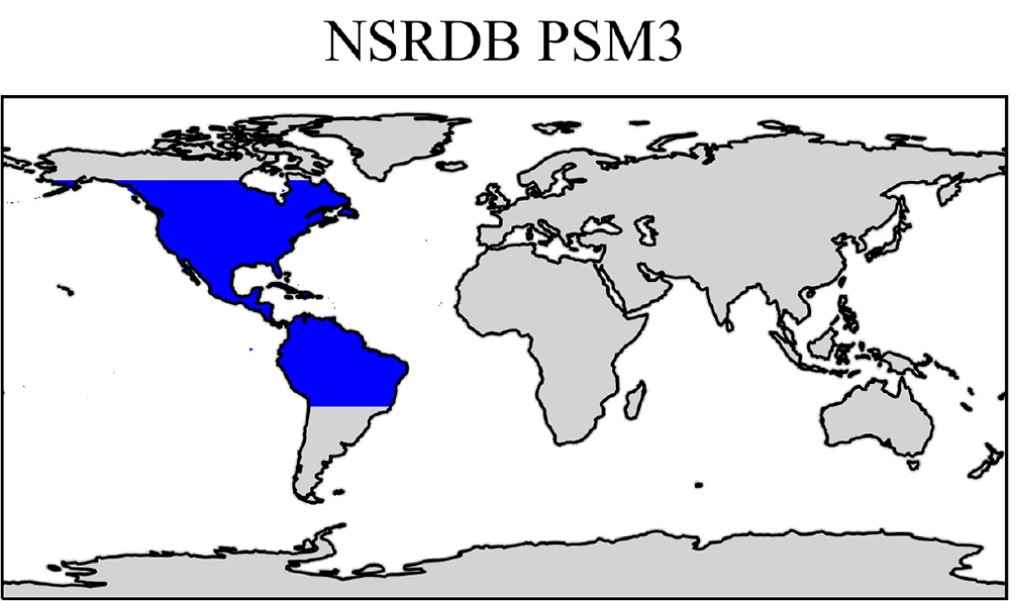

In [11]:
API_KEY = 'your_api_key_here'
# The example API key here is for demonstation and is rate-limited per IP.
# To get your own API key, visit https://developer.nrel.gov/signup/

weather_db = 'PSM3'
weather_id = (39.741931, -105.169891)
weather_arg = {'api_key': 'DEMO_KEY',
               'email': 'user@mail.com',
               'names': 'tmy',
               'attributes': [],
               'map_variables': True}

weather_df, meta = pvdeg.weather.get(weather_db, weather_id, **weather_arg)
# Perform calculation and output interpretation or results
res = pvdeg.standards.standoff(weather_df=weather_df, meta=meta, tilt=None, azimuth=180, sky_model='isotropic', temp_model='sapm',
    conf_0='insulated_back_glass_polymer', conf_inf='open_rack_glass_polymer', T98=70, x_0=6.5, wind_factor=0.33)
print(pvdeg.standards.interpret_standoff(res))
print(meta)


Column "relative_humidity" not found in DataFrame. Calculating...
The estimated temperature of an insulated-back module is 73.5°C. 
The estimated temperature of an open-rack module is 50.0°C. 
Level 0 certification is valid for a standoff greather than 1.0 cm. 
Level 1 certification is required for a standoff less than 1.0 cm. 
Level 2 certification is never required for this temperature profile.
{'Source': 'NSRDB', 'Location ID': '145809', 'City': '-', 'State': '-', 'Country': '-', 'Dew Point Units': 'c', 'DHI Units': 'w/m2', 'DNI Units': 'w/m2', 'GHI Units': 'w/m2', 'Temperature Units': 'c', 'Pressure Units': 'mbar', 'Wind Direction Units': 'Degrees', 'Wind Speed Units': 'm/s', 'Surface Albedo Units': 'N/A', 'Version': '3.2.0', 'latitude': 39.73, 'longitude': -105.18, 'altitude': 1820, 'timezone': -7, 'wind_height': 2, 'tz': -7}


## 3. PVGIS

This method uses the PVGIS database, a public resource. It requires no API key or user account. This method will work in the PVGIS-SARAH and the PVGIS-SARAH2 regions.

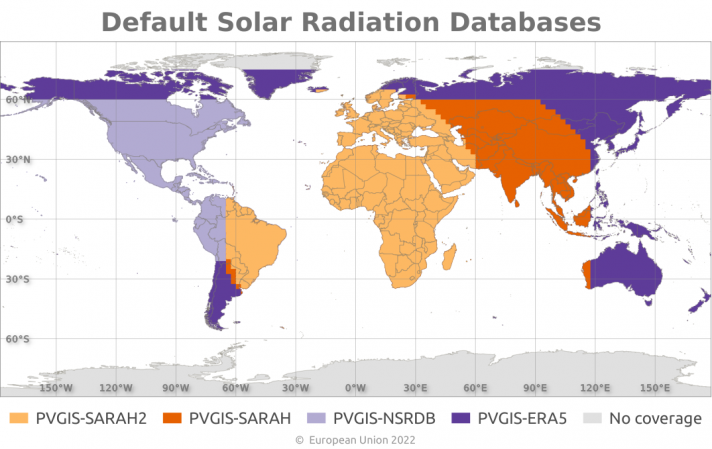

In [12]:
weather_db = 'PVGIS'
#weather_id = (39.741931, -105.169891)
weather_id = (24.7136, 46.6753) #Riyadh, Saudi Arabia
#weather_arg = {'map_variables': True}

# TMY
weather_df, meta = pvdeg.weather.get(weather_db, weather_id)

# Perform calculation
res = pvdeg.standards.standoff(weather_df=weather_df, meta=meta, tilt=None, azimuth=180, sky_model='isotropic', temp_model='sapm',
    conf_0='insulated_back_glass_polymer', conf_inf='open_rack_glass_polymer', T98=70, x_0=6.5, wind_factor=0.33)
print(pvdeg.standards.interpret_standoff(res))
print(meta)


The estimated temperature of an insulated-back module is 89.6°C. 
The estimated temperature of an open-rack module is 63.8°C. 
Level 0 certification is valid for a standoff greather than 9.3 cm. 
Level 1 certification is required for a standoff between than 9.3 cm, and 3.0 cm. 
Level 2 certification is required for a standoff less than 3.0 cm.
{'latitude': 24.7136, 'longitude': 46.6753, 'altitude': 646.0, 'wind_height': 10, 'Source': 'PVGIS'}
